# General descriotion
In this motebook the 

## Global imports

In [1]:
import sys
import os

import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse

import torch
from PIL import Image
from IPython.display import clear_output
import time
from enum import Enum

os.getcwd()

'/home/roman_kiryanov'

In [2]:
import tifffile as tiff

## Class for data manipulations

In [3]:
class microscope_info:
    extension='.tif'
    folder_Z1_original = './data_Z1/tiffs/'
    folder_ultra_original = './data_LightSheet/'
    dtype = np.uint8
    
    @staticmethod
    def _sort_rule_Z1(name):
        return int(name.split(' ')[-1].split('.')[0])
    
    @staticmethod
    def _sort_rule_light_sheet(name):
        return int( name.split('.')[0].split('section')[-1] )
    
    @staticmethod
    def preprocess(image):
        return image
    
    def __init__(self):
        self.name = None
        self.folder = None
        self.sorting_rule = None


        
class z1(microscope_info):
    def __init__(self):
        super().__init__()
        self.name = 'z1'
        self.folder = self.folder_Z1_original
        self.sorting_rule = self._sort_rule_Z1
        
    @staticmethod
    def preprocess(image):
        image = image[:,:,0]
        image = image.T
        return image.astype(np.uint8)


    
class ls(microscope_info):
    def __init__(self):
        self.name = 'ls'
        self.folder = self.folder_ultra_original
        self.sorting_rule = self._sort_rule_light_sheet
    
    @staticmethod
    def preprocess(image):
        image = 255*image.astype(np.float32)/65536
        return image.astype(np.uint8)

In [4]:
class stack3D:   
    _preview_height = 500
    _preview_cmap = 'gray'
    
    def _load_slice(self, img_name):
        img_slice = cv2.imread(os.path.join(self._folder, img_name), -1)     
        img_slice = self._image_preprocess(img_slice)
        return img_slice
        
    def _load_example(self, idx=None):
        if idx:
            img_name = self.slices[idx]
            print('example:', img_name)
        else:
            img_name = np.random.choice(self.slices)
            print('random example:', img_name)
            
        img_slice = self._load_slice(img_name)
        ndims, x_y_shape, data_type = img_slice.ndim, img_slice.shape[:2], img_slice.dtype
        return img_slice, ndims, x_y_shape, data_type
    
    def preview(self, image, axes, resize=True):
        if resize:
            img_res = imutils.resize(image, height=self._preview_height)
        else:
            img_res = image
        axes.imshow(img_res, cmap=self._preview_cmap)
        axes.set_xlim(0, img_res.shape[1])
        axes.set_ylim(img_res.shape[0], 0)
        x_ticks = axes.get_xticks()
        y_ticks = axes.get_yticks()
        
        x_ticks_labels = np.linspace(0,image.shape[1],len(x_ticks), dtype=int)
        y_ticks_labels = np.linspace(0,image.shape[0],len(y_ticks), dtype=int)
        axes.set_xticklabels(x_ticks_labels)
        axes.set_yticklabels(y_ticks_labels)
        axes.set_xlabel('x', fontsize=14)
        axes.set_ylabel('y', fontsize=14)
        return axes
    
    @staticmethod
    def _convert_memory_values(value):
        v_type = 'bits'
        if value > 8:
            value /= 8
            v_type = 'bytes'
        if value > 1024:
            value /= 1024
            v_type = 'kilobytes'
        if value > 1024:
            value /= 1024
            v_type = 'megabytes'
        if value > 1024:
            value /= 1024
            v_type = 'gigabytes'
        return round(value,2), v_type
    
    def _estimate_memory(self, size=None):
        if self._loading_dtype == np.uint8:
            bits = 8
        elif self._loading_dtype == np.float32:
            bits = 32
            
        if size is None:
            slice_memory = self._slice_shape[0]*self._slice_shape[1]*bits
            full_stack_memory = len(self.slices)*slice_memory
            return self._convert_memory_values(slice_memory), self._convert_memory_values(full_stack_memory)   
        else:
            mem_bits = size*bits
            return self._convert_memory_values(mem_bits)
    
    
    def __init__(self, microscope):
        self._folder = microscope.folder
        self._image_preprocess = microscope.preprocess
        self._extension = microscope.extension
        self._loading_dtype = microscope.dtype
        
        # Read information about all images available
        # Sort images to left only with correct extension
        # Sort images in growing order
        names_list = os.listdir(self._folder)
        names_list = [img for img in names_list if img.endswith(self._extension)]
        names_list.sort(key = microscope.sorting_rule)
        self.slices = names_list
        
        # Read data about stack 
        example_slice, self._ndim, self._slice_shape, self._dtype = self._load_example()
        memory_results = self._estimate_memory()
        
        # Visualize
        print('Num of slices:', len(self.slices), ', slice shape:', self._slice_shape, ', initial dtype:', self._dtype)
        print('Slice memory:', memory_results[0][0],memory_results[0][1]+';', 
              'Brain memory:', memory_results[1][0], memory_results[1][1])
        fig, axes = plt.subplots(1,1)
        fig.set_figheight(6)
        fig.set_figwidth(8)
        axes = self.preview(example_slice, axes)
        plt.show()
        del example_slice
        
    def get_sample(self, coordinates:tuple=None):
        # x - along width (slice.shape[1])
        # y - along height (slice.shape[0])
        # z - along slices (self.slices)
        if coordinates is not None:
            ((x_0,x_1), (y_0,y_1), (z_0,z_1)) = coordinates
        else:
            size = 250
            x_0 = np.random.randint( self._slice_shape[1]*0.1, min(self._slice_shape[1]*0.9, self._slice_shape[1]-size) )
            x_1 = x_0 + size
            
            y_0 = np.random.randint( self._slice_shape[0]*0.1, min(self._slice_shape[0]*0.9, self._slice_shape[0]-size) )
            y_1 = y_0 + size
            
            total_slices = len(self.slices)
            z_size = 5
            z_0 = np.random.randint( int(total_slices*0.2), int(total_slices*0.7))
            z_1 = z_0 + z_size
            coordinates = ((x_0,x_1), (y_0,y_1), (z_0,z_1))
        
        print('x:',coordinates[0], 'y:',coordinates[1], 'z:',coordinates[2])
        
        if z_1 == z_0:
            # One 2D slcie
            slices_to_load = self.slices[z_0:z_0+1]
        else:
            # Several slices
            slices_to_load = self.slices[z_0:z_1]
        memory_results = self._estimate_memory( (y_1-y_0)*(x_1-x_0)*(z_1-z_0) )
        if memory_results[1] in ['bits', 'bytes', 'kilobytes', 'megabytes']:
            pass
        else:
            raise Exception('The asked sample is too large to be loaded')
        
        sample = np.zeros((y_1-y_0, x_1-x_0, z_1-z_0), dtype = self._loading_dtype)
        for z_idx, img_name in enumerate( slices_to_load ):
            tmp_slice = self._load_slice(img_name)
            sample[:,:,z_idx] = tmp_slice[y_0:y_1, x_0:x_1]
        return sample
    
    def projections(self, image, transpose=True, flip=False, resize=False):
        self.max_projections(image, transpose=transpose, flip=flip, resize=resize)
    
    def max_projections(self, image, transpose=True, flip=False, resize=False):
        if len(image.shape) < 3:
            raise Exception('Can not build projections for non-3D image')
        proj_1 = np.max(image, 0)
        proj_2 = np.max(image, 1)
        proj_3 = np.max(image, 2)
        if transpose:
            proj_1 = np.transpose(proj_1, (1,0))
            proj_2 = np.transpose(proj_2, (1,0))
        if flip:
            proj_1 = np.flip(proj_1, 0)
            proj_2 = np.flip(proj_2, 0)
        
        
        fig, axes = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(14)
        axes[0][0] = self.preview(proj_1, axes[0][0], resize)
        axes[0][0].set_ylabel('z', fontsize=14)
        
        axes[0][1] = self.preview(proj_2, axes[0][1], resize)
        axes[0][1].set_ylabel('z', fontsize=14)
        axes[0][1].set_xlabel('y', fontsize=14)
        
        axes[1][0] = self.preview(proj_3, axes[1][0], resize)
        axes[1][1].axis('off')
        plt.show()
        
    def idx_projections(self, image, slice_x, slice_y, slice_z, transpose=True, flip=False, resize=False):
        if len(image.shape) < 3:
            raise Exception('Can not build projections for non-3D image')
        proj_1 = image[slice_x,:,:]
        proj_2 = image[:,slice_y,:]
        proj_3 = image[:,:,slice_z]
        if transpose:
            proj_1 = np.transpose(proj_1, (1,0))
            proj_2 = np.transpose(proj_2, (1,0))
        if flip:
            proj_1 = np.flip(proj_1, 0)
            proj_2 = np.flip(proj_2, 0)
        
        
        fig, axes = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(14)
        axes[0][0] = self.preview(proj_1, axes[0][0], resize)
        axes[0][0].set_ylabel('z', fontsize=14)
        
        axes[0][1] = self.preview(proj_2, axes[0][1], resize)
        axes[0][1].set_ylabel('z', fontsize=14)
        axes[0][1].set_xlabel('y', fontsize=14)
        
        axes[1][0] = self.preview(proj_3, axes[1][0], resize)
        axes[1][1].axis('off')
        plt.show()

# Models

In [5]:
sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/')
sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/models/archs/')
import RRDBNet_arch as arch

In [21]:
device = torch.device(2) 
#device = 'cpu' 
print(os.getcwd())

esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
esrgan.load_state_dict(torch.load('./mmsr/experiments/pretrained_models/RRDB_ESRGAN_x4.pth'), strict=True)
esrgan.eval()
esrgan = esrgan.to(device)

# 18.01.2020
fine_tune_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
fine_tune_esrgan.load_state_dict(torch.load('./mmsr/experiments/1801_RRDB_ESRGANx4_Z1/models/10000_G.pth'), strict=True)
fine_tune_esrgan.eval()
fine_tune_esrgan = fine_tune_esrgan.to(device)

/home/roman_kiryanov


In [22]:
from collections import OrderedDict

alpha = 0.5

net_interp = OrderedDict()
net_finetune = torch.load('./mmsr/experiments/1801_RRDB_ESRGANx4_Z1/models/10000_G.pth')
net_ESRGAN = torch.load('./mmsr/experiments/pretrained_models/RRDB_ESRGAN_x4.pth')
net_interp = OrderedDict()

print('Interpolating with alpha = ', alpha)

for k, v_PSNR in net_finetune.items():
    v_ESRGAN = net_ESRGAN[k]
    net_interp[k] = (1 - alpha) * v_PSNR + alpha * v_ESRGAN
    
interp_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
interp_esrgan.load_state_dict(net_interp, strict=True)
interp_esrgan.eval()
interp_esrgan = interp_esrgan.to(device)

Interpolating with alpha =  0.5


In [8]:
def predict(model, image, device=device):
    image = np.transpose([image,image,image], (1,2,0))
    
    image = torch.from_numpy(np.transpose(image[:, :, [2, 1, 0]], (2, 0, 1))).float()
    image = image/255
    image = image.unsqueeze(0)
    image = image.to(device)

    # Generate eSRGAN image
    with torch.no_grad():
        image_cpu = model(image)
    image_cpu = image_cpu.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    del image
    image_cpu = np.transpose(image_cpu[[2, 1, 0], :, :], (1, 2, 0))
    image_cpu = np.clip(image_cpu*255, 0,255)
    image_cpu = image_cpu.astype(np.uint8)
    
    torch.cuda.empty_cache()
    return image_cpu[:,:,0]

## Deconvolution

In [9]:
from skimage import restoration

In [10]:
def extract_psf(image, kernel, normalize = False):
    assert (image.shape[0] >= kernel.shape[0]) and (image.shape[1] >= kernel.shape[1]), 'Kernel is less than image'
    drop_channel = False
    if image.ndim ==2:
        image = np.expand_dims(image, 2)
        kernel = np.expand_dims(kernel, 2)
        drop_channel = True
    psf = np.zeros_like(image).astype(np.float32)
    
    for z in range(image.shape[2]):
        blurred_2d_image = image[:,:,z].astype(np.float32)/255
        kernel_2d_image = kernel[:,:,z].astype(np.float32)/255
        
        #print(kernel_2d_image.shape, kernel_2d_image.dtype, kernel_2d_image.max(), kernel_2d_image.min())
        
        ### Experiment
        blurred_2d_image /= np.sum(blurred_2d_image)
        kernel_2d_image /= np.sum(kernel_2d_image)
        
        dec_psf = restoration.unsupervised_wiener(blurred_2d_image, kernel_2d_image)[0]
        
        if normalize:
            dec_psf = dec_psf*(dec_psf>0)
            dec_psf = dec_psf/dec_psf.sum()
            #dec_psf = dec_psf/dec_psf.max()
        psf[:,:,z] = dec_psf
    
    if drop_channel:
        psf = np.squeeze(psf,2)
    return psf

In [11]:
def restore(img, z, depth, gan):
    input_substack = np.zeros((img.shape[0], img.shape[1], 2*depth+1))
    if (z-depth) < 0:
        z += depth
    elif (z+depth) >= img.shape[2]:
        z = img.shape[2]- depth
    
    for z_idx, i in enumerate( range(-depth, depth+1) ):
        input_substack[:,:,z_idx] = img[:,:,z+i]
        #print(z+i)
    
    center = depth
    generated = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    bicubic = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    for i in range(input_substack.shape[2]):
        generated[:,:,i] = predict(gan, input_substack[:,:,i])
        bicubic[:,:,i] = cv2.resize(input_substack[:,:,i], (int(img.shape[1]*4), int(img.shape[0]*4)), cv2.INTER_CUBIC)
    
    print('Images generated')
    psf_v1 = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    psf_v2 = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    for i in range(input_substack.shape[2]):
        psf_v1[:,:,i] = extract_psf(bicubic[:,:,i], generated[:,:,i], normalize=False)
        
    print('psf_1 extracted')
    for i in np.arange(-depth, 0, 1):
        psf_v2[:,:,center+i] = extract_psf(bicubic[:,:,center+i], generated[:,:,center], normalize=False)
    
    psf_v2[:,:,center] = extract_psf(bicubic[:,:,center], generated[:,:,center], normalize=False)
    for i in np.arange(1, depth+1, 1):
        psf_v2[:,:,center+i] = extract_psf(bicubic[:,:,center+i], generated[:,:,center], normalize=False)
    print('psf_2 extracted')
    
    return psf_v1, psf_v2

In [12]:
def montage(images, cmap='gray'):
    width = images[0].shape[0]
    
    placeholder = np.zeros(
        (width, width*len(images))
    )
    for i in range(len(images)):
        placeholder[:, i*width:(i+1)*width] = images[i]
        
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(6)
    fig.set_figwidth(len(images)*3)
    
    ax.imshow(placeholder, cmap=cmap)
    
    ax.set_xticks([i*width for i in range(len(images)+1)])
    ax.set_xticklabels([str(i+1) for i in range(len(images)+1)], fontsize=12)
    ax.minorticks_off()
    ax.set_xlim(0, width*len(images))
    
    plt.show()

# Data

random example: section0400.tif
Num of slices: 402 , slice shape: (802, 1040) , initial dtype: uint8
Slice memory: 814.53 kilobytes; Brain memory: 319.77 megabytes


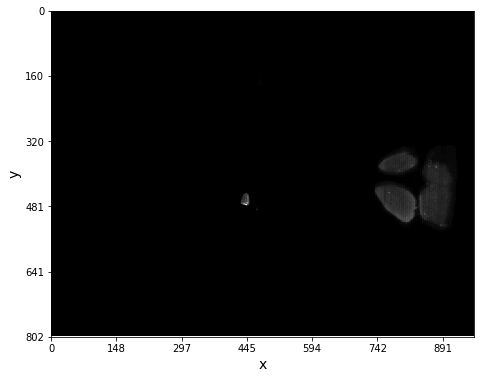

In [12]:
ls_ex = ls()
brain = stack3D(ls_ex)

In [ ]:
x_brain, y_brain, z_brain = np.random.randint(300,500), np.random.randint(150,550), np.random.randint(100,350)

x: (392, 492) y: (542, 642) z: (346, 396)


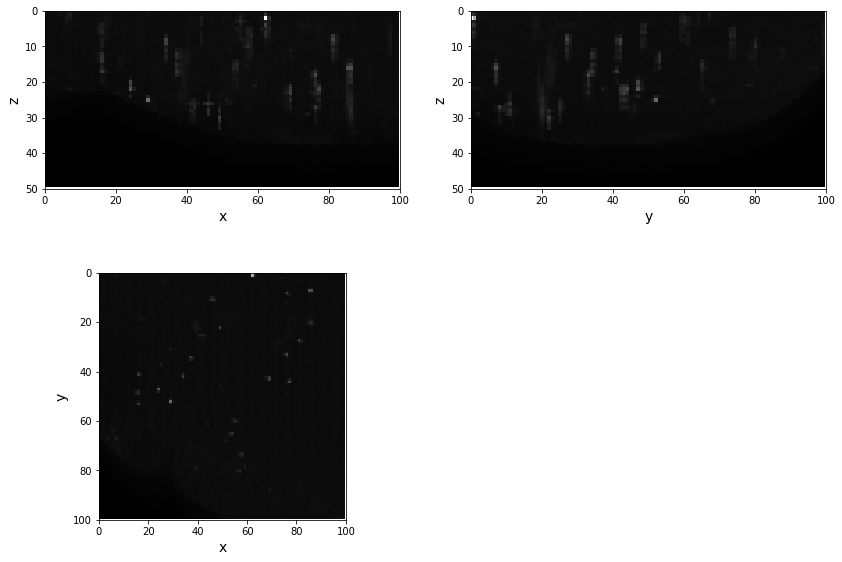

In [13]:
img_2 = brain.get_sample(  ((x_brain, x_brain+100),(y_brain, y_brain+100), (z_brain, z_brain+50)) )
brain.projections(img_2 , transpose=True, resize=False)

In [327]:
depth = 4

crop = 30
cmap = 'jet'

### Interpolated eSRGAN, one PSF

In [359]:
_, psf_interp_esrgan = restore(img_2, 25, depth, interp_esrgan)

Images generated
psf_1 extracted
psf_2 extracted


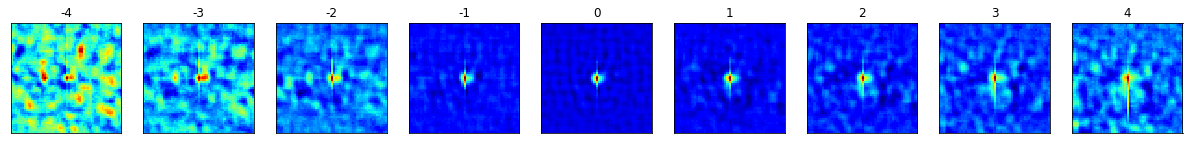

In [360]:
middle = psf_interp_esrgan.shape[0]//2

fig, axes = plt.subplots(nrows=1, ncols = psf_interp_esrgan.shape[2])
fig.set_figheight(8)
fig.set_figwidth(21)

middle_max = np.max(
    psf_interp_esrgan[middle-crop:middle+crop, middle-crop:middle+crop, depth]
)

for ax, psf_slice in zip(axes, range(psf_interp_esrgan.shape[2])):
    
    psf_2_crop = psf_interp_esrgan[
        middle-crop:middle+crop, 
        middle-crop:middle+crop, 
        psf_slice
    ]
    
    test_psf_3 = psf_2_crop
    test_psf_3 = test_psf_3/middle_max 
    
    test_psf_3 = test_psf_3 + np.abs(np.min(test_psf_3))
    ax.imshow( test_psf_3, cmap=cmap )
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(str(psf_slice - psf_interp_esrgan.shape[2]//2))
plt.show()

In [361]:
z = img_2.shape[2]//2

_, psf_interp_esrgan_multiple = restore(img_2, 25, depth, interp_esrgan)
stride = 10

for z in range(depth, img_2.shape[2]-depth, stride):
    _, psf2_t = restore(img_2, z, depth, interp_esrgan)
    psf_interp_esrgan_multiple = np.mean([psf_interp_esrgan_multiple, psf2_t], axis=0)

Images generated
psf_1 extracted
psf_2 extracted
Images generated
psf_1 extracted
psf_2 extracted
Images generated
psf_1 extracted
psf_2 extracted
Images generated
psf_1 extracted
psf_2 extracted
Images generated
psf_1 extracted
psf_2 extracted
Images generated
psf_1 extracted
psf_2 extracted


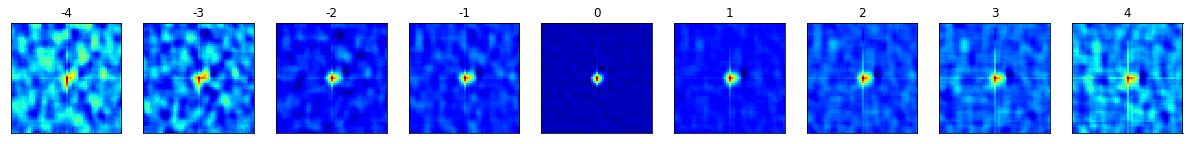

In [362]:
middle = psf_interp_esrgan_multiple.shape[0]//2

fig, axes = plt.subplots(nrows=1, ncols = psf_interp_esrgan_multiple.shape[2])
fig.set_figheight(8)
fig.set_figwidth(21)

middle_max = np.max(
    psf_interp_esrgan_multiple[middle-crop:middle+crop, middle-crop:middle+crop, depth]
)

for ax, psf_slice in zip(axes, range(psf_interp_esrgan_multiple.shape[2])):
    
    psf_2_crop = psf_interp_esrgan_multiple[
        middle-crop:middle+crop, 
        middle-crop:middle+crop, 
        psf_slice
    ]
    
    test_psf_3 = psf_2_crop
    test_psf_3 = test_psf_3/middle_max 
    
    test_psf_3 = test_psf_3 + np.abs(np.min(test_psf_3))
    ax.imshow( test_psf_3, cmap=cmap )
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(str(psf_slice - psf_interp_esrgan_multiple.shape[2]//2))
plt.show()

## Original eSRGAN

In [363]:
_, psf_original_esrgan = restore(img_2, 25, depth, esrgan)

Images generated
psf_1 extracted
psf_2 extracted


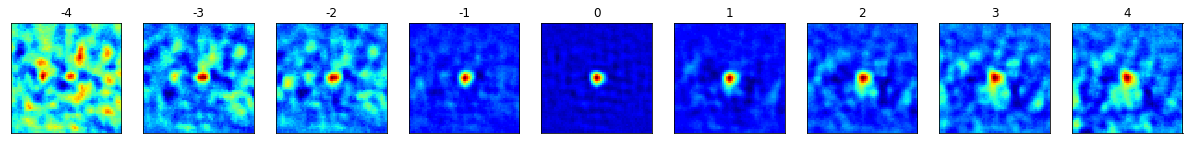

In [364]:
middle = psf_original_esrgan.shape[0]//2

fig, axes = plt.subplots(nrows=1, ncols = psf_original_esrgan.shape[2])
fig.set_figheight(8)
fig.set_figwidth(21)

middle_max = np.max(
    psf_original_esrgan[middle-crop:middle+crop, middle-crop:middle+crop, depth]
)

for ax, psf_slice in zip(axes, range(psf_original_esrgan.shape[2])):
    
    psf_2_crop = psf_original_esrgan[
        middle-crop:middle+crop, 
        middle-crop:middle+crop, 
        psf_slice
    ]
    
    test_psf_3 = psf_2_crop
    test_psf_3 = test_psf_3/middle_max 
    
    test_psf_3 = test_psf_3 + np.abs(np.min(test_psf_3))
    ax.imshow( test_psf_3, cmap=cmap )
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(str(psf_slice - psf_original_esrgan.shape[2]//2))
plt.show()

In [372]:
import numpy as np
from scipy.stats import multivariate_normal

In [373]:
def create_3d_psf_gaussian(xy_size, z_size, x_sigma,y_sigma,z_sigma):
    x, y, z  = np.mgrid[-1.0 : 1.0 : xy_size,  -1.0 :1.0 : xy_size, -1.0 :1.0 : z_size]
    xyz = np.column_stack([x.flat, y.flat, z.flat])
    
    mu = np.array([0.0, 0.0, 0.0])
    sigma = np.array([x_sigma, y_sigma, z_sigma])
    covariance = np.diag(sigma**2)

    z = multivariate_normal.pdf(xyz, mean=mu, cov=covariance)
    z /= z.sum()
    z = z.reshape(x.shape)
    return z

In [376]:
esrgan_psf = psf_original_esrgan[
    middle-crop:middle+crop, 
    middle-crop:middle+crop,
    :
]

interpolate_psf = psf_interp_esrgan[
    middle-crop:middle+crop, 
    middle-crop:middle+crop,
    :
]

original_psf = create_3d_psf_gaussian(60j, 9j, 0.06, 0.06, 0.13*4)

Original: min 0.0, max 0.0093


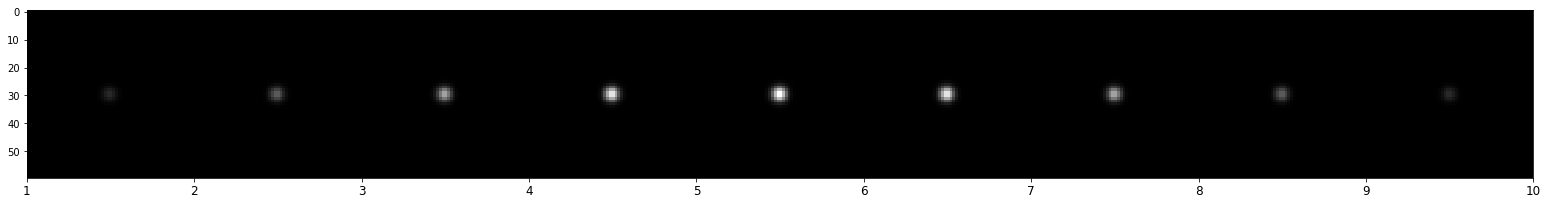

Original: min -0.0044, max 0.03


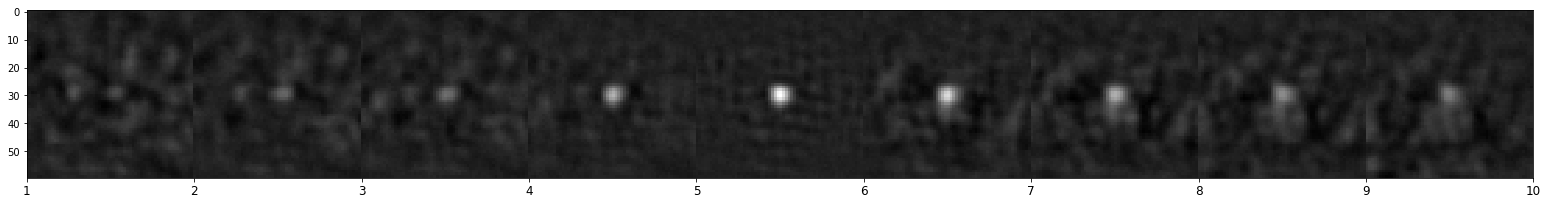

Original: min -0.0062, max 0.0543


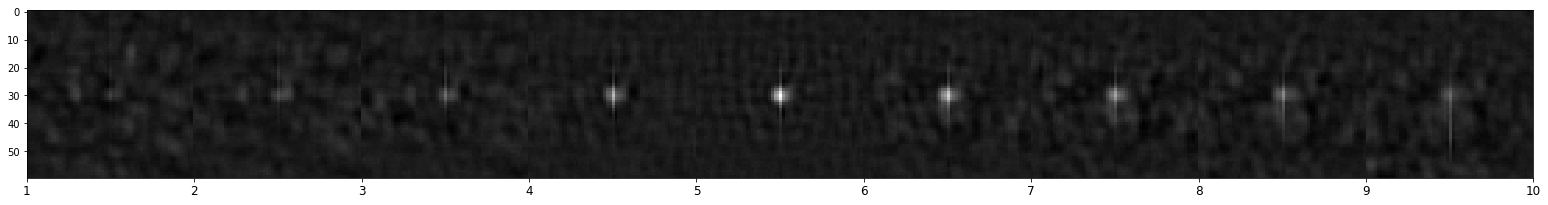

In [377]:
print(f'Original: min {round(original_psf.min(),4)}, max {round(original_psf.max(),4)}')
montage([original_psf[:,:,i] for i in range(original_psf.shape[2])])

print(f'Original: min {round(esrgan_psf.min(),4)}, max {round(esrgan_psf.max(),4)}')
montage([esrgan_psf[:,:,i] for i in range(esrgan_psf.shape[2])])

print(f'Original: min {round(interpolate_psf.min(),4)}, max {round(interpolate_psf.max(),4)}')
montage([interpolate_psf[:,:,i] for i in range(interpolate_psf.shape[2])])

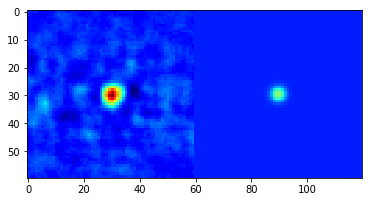

In [378]:
idx = 3

psf_2_crop = psf_original_esrgan[
    middle-crop:middle+crop, 
    middle-crop:middle+crop,
    idx
]

plt.imshow(np.hstack([psf_2_crop, original_psf[:,:,idx]]), cmap='jet')
plt.show()

In [380]:
folder_to_save = './real_data_psf_extracted_03052020/'

In [381]:
for i in range(9):
    tmp = 255*original_psf[:,:,i] / original_psf.max()

    tiff.imsave( 
        os.path.join(folder_to_save, 'gt', 'psf_extracted_C0000Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint8(tmp) 
    )

In [284]:
for i in range(9):
    tmp = 255*(np.clip(esrgan_psf[:,:,i], 0, esrgan_psf.max())) / esrgan_psf.max()
    
    tiff.imsave( 
        os.path.join(folder_to_save, 'original_esrgan', 'psf_extracted_C0001Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint8(tmp) 
    )

In [285]:
for i in range(9):
    tmp = 255*(np.clip(interpolate_psf[:,:,i], 0, interpolate_psf.max())) / interpolate_psf.max()
    
    tiff.imsave( 
        os.path.join(folder_to_save, 'interp_esrgan', 'psf_extracted_C0002Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint8(tmp) 
    )

### Crop for cell calculation

random example: section0165.tif
Num of slices: 402 , slice shape: (802, 1040) , initial dtype: uint8
Slice memory: 814.53 kilobytes; Brain memory: 319.77 megabytes


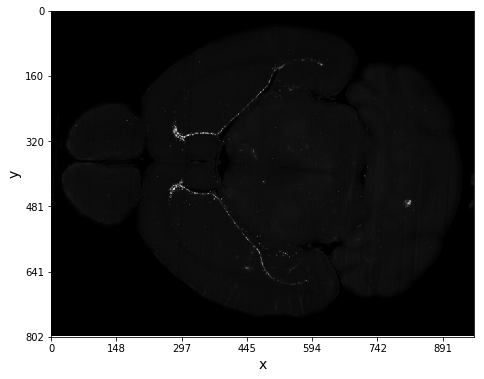

In [45]:
ls_ex = ls()
brain = stack3D(ls_ex)

x: (520, 600) y: (550, 630) z: (120, 200)


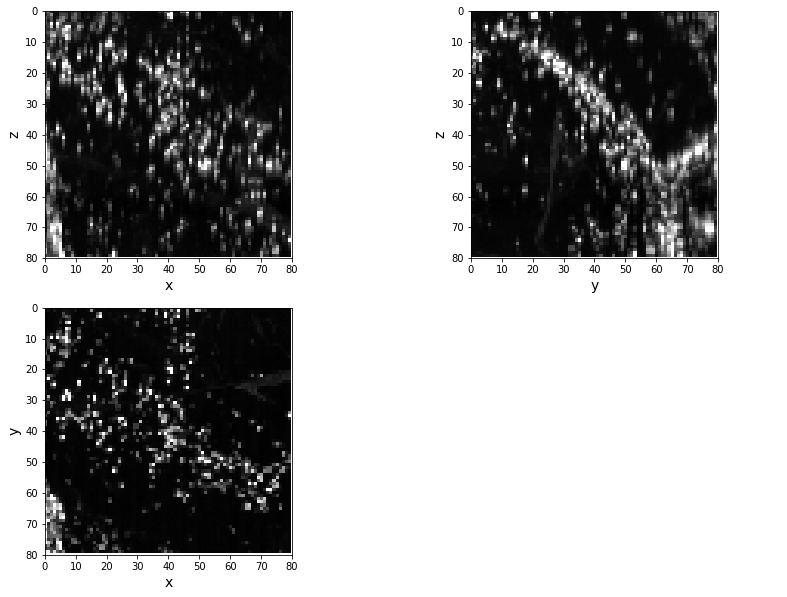

In [64]:
img = brain.get_sample(  ((520, 600),(550, 630), (120, 200)) )

#img = img[:,:,::2]
brain.projections(img, transpose=True, resize=False)

bicubic_slices


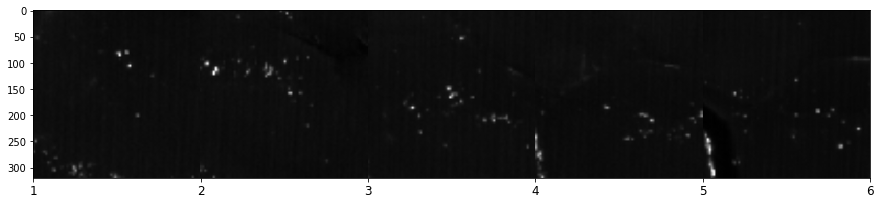

iesrgan_slices


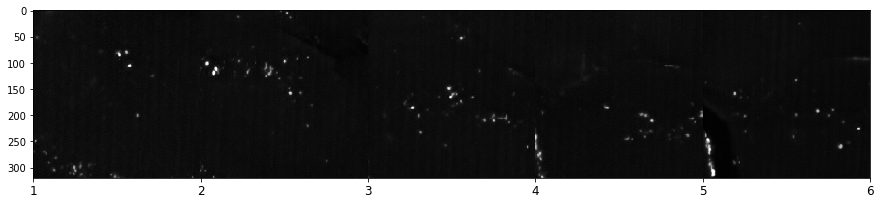

In [76]:
bicubic_slices = np.zeros((img.shape[0]*4, img.shape[1]*4, img.shape[2]))
iesrgan_slices = np.zeros((img.shape[0]*4, img.shape[1]*4, img.shape[2]))

for z in range(img.shape[2]):
    iesrgan_slices[:,:,z] = predict(interp_esrgan, img[:,:,z])
    bicubic_slices[:,:,z] = cv2.resize(
        img[:,:,z], (int(img.shape[1]*4), int(img.shape[0]*4)), cv2.INTER_CUBIC
    )

bicubic_slices_2 = np.zeros((img.shape[0]*4, img.shape[1]*4, img.shape[2]*4))
iesrgan_slices_2 = np.zeros((img.shape[0]*4, img.shape[1]*4, img.shape[2]*4))

for z in range(iesrgan_slices.shape[0]):
    iesrgan_slices_2[z,:,:] = cv2.resize(
        iesrgan_slices[z,:,:], (int(iesrgan_slices.shape[1]), int(iesrgan_slices.shape[2]*4)), 
        cv2.INTER_CUBIC
    )
    bicubic_slices_2[z,:,:] = cv2.resize(
        bicubic_slices[z,:,:], (int(bicubic_slices.shape[1]), int(bicubic_slices.shape[2]*4)), 
        cv2.INTER_CUBIC
    )

print(f'bicubic_slices')
montage([bicubic_slices_2[:,:,i] for i in range(0, bicubic_slices_2.shape[2], 70)])

print(f'iesrgan_slices')
montage([iesrgan_slices_2[:,:,i] for i in range(0, iesrgan_slices_2.shape[2], 70)])

In [85]:
img.shape, bicubic_slices_2.shape, iesrgan_slices_2.shape

((80, 80, 80), (320, 320, 320), (320, 320, 320))

In [89]:
folder_to_save = 'real_data_ls_to_cell_counting_crop_520-600_550-630_120-200_09052020'

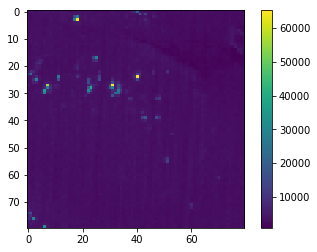

In [102]:
plt.imshow( np.uint16(65535*(img[:,:,16]/255)))
plt.colorbar()

In [103]:
for i in range(80):
    tmp = 65535*(img[:,:,i] / 255)

    tiff.imsave( 
        os.path.join(folder_to_save, 'input', 'crop_input_C0000Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint16(tmp) 
    )

In [84]:
for i in range(80):
    tmp = 65535*img[:,:,i] / 255

    tiff.imsave( 
        os.path.join(folder_to_save, 'input', 'crop_input_C0000Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint16(tmp) 
    )
    
for i in range(320):
    tmp = 65535*bicubic_slices_2[:,:,i] / 255

    tiff.imsave( 
        os.path.join(folder_to_save, 'bicubic', 'crop_bicubic_C0001Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint16(tmp) 
    )
    
for i in range(320):
    tmp = 65535*iesrgan_slices_2[:,:,i] / 255

    tiff.imsave( 
        os.path.join(folder_to_save, 'int_esrgan', 'crop_intesrgan_C0002Z'+'{:04d}'.format(i)+'.tif'), 
        np.uint16(tmp) 
    )
    
print('saved')

saved
